# Basic Model Prototyping

Builds off of Cheng's training notebook, with some added features and models

### Install MXNet and GluonCV

In [2]:
!pip install --upgrade mxnet-cu101 gluoncv

     |████████████████████████████████| 711.7MB 108kB/s eta 0:00:011     |████████████▌                   | 276.9MB 14.9MB/s eta 0:00:30████████████████████████      | 579.9MB 19.9MB/s eta 0:00:07�████████████████████▏  | 647.6MB 12.6MB/s eta 0:00:06
     |████████████████████████████████| 819kB 10.3MB/s eta 0:00:01


### Import necessary packages

In [4]:
import mxnet as mx
import numpy as np
import os, time, shutil

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.model_zoo import get_model

import matplotlib.pyplot as plt
# %matplotlib inline

### Data preparation

In [5]:
# I moved the original data preparation blocks to the local py file
# after getting the split train/val/test data, I uploaded them back to Google Drive
# directly specify directories
path = '/content/gdrive/My Drive/Dataset/embryo-58-bf-image-1503-order-random'
fluo_path = '/content/gdrive/My Drive/Dataset/embryo-58-fluo-image-1503-order-random'

train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
fluo_test_path = os.path.join(fluo_path, 'test') # read in the fluorescence channel for comparison

### Data augmentation

In [6]:
npzfile = np.load(os.path.join(path, 'mean_std.npz'))
X_mean = npzfile['X_mean'].tolist()
X_std = npzfile['X_std'].tolist()
print(X_mean,X_std)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/Dataset/embryo-58-bf-image-1503-order-random/mean_std.npz'

In [ ]:
# z-score standardize the data
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([X_mean], [X_std])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([X_mean], [X_std])
])

### Set hyperparameters 

In [ ]:
classes = 2

per_device_batch_size = 16
num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

### Define data loader

When training machine learning models it is important to shuffle the training samples every time you pass through the dataset (i.e. each epoch)

https://mxnet.apache.org/versions/1.2.1/tutorials/gluon/datasets.html

In [ ]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

# read in the fluorescence channel for comparison
fluo_test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(fluo_test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

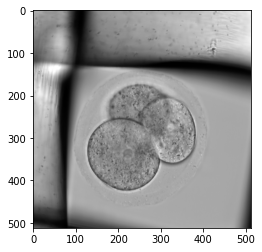

In [ ]:
# visualize an image in train_data
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X_batch, y_batch = next(iter(train_data))

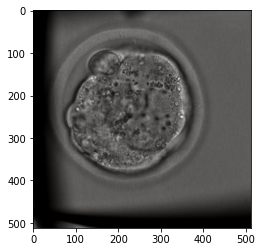

In [ ]:
viz_image = X_batch[4,:,:,:]
plt.figure()
plt.imshow(NormalizeData(np.swapaxes(np.squeeze(viz_image.asnumpy()),0,2)))

### Model


In [ ]:
model_name = 'ResNet50_v2'
# Fine-tuning pre-trained models: train model on my new data using the pre-trained weights as initialization -- transfer learning
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
# # Train from scratch: however note that you cannot use the pretrained and classes parameter at the same time!!!
# vanilla_net = get_model(model_name, classes=classes)

finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

92863KB [00:03, 26190.80KB/s]                           


### Optimizer, Loss and Metric

In [ ]:
lr = 0.001
lr_factor = 0.75 # Learning rate decay factor
lr_steps = [10, 20, 30, np.inf] # Epochs where learning rate decays
wd = 0.0001
momentum = 0.9
optimizer = 'sgd' # 'nag': Nesterov accelerated gradient descent
optimizer_params = {'learning_rate': lr, 'wd': wd, 'momentum': momentum} # Set parameters
trainer = gluon.Trainer(finetune_net.collect_params(), optimizer, optimizer_params)

L = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc', 'validation-acc'])

In [ ]:
# define an evaluation function for validation and testing
def test(net, test_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(test_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

### Training

[Epoch 0] Train-acc: 0.779, loss: 0.431 | Val-acc: 0.807 | time: 60.2
[Epoch 1] Train-acc: 0.894, loss: 0.235 | Val-acc: 0.814 | time: 35.0
[Epoch 2] Train-acc: 0.909, loss: 0.205 | Val-acc: 0.855 | time: 35.1
[Epoch 3] Train-acc: 0.932, loss: 0.164 | Val-acc: 0.862 | time: 35.0
[Epoch 4] Train-acc: 0.946, loss: 0.134 | Val-acc: 0.845 | time: 35.0
[Epoch 5] Train-acc: 0.956, loss: 0.104 | Val-acc: 0.866 | time: 35.2
[Epoch 6] Train-acc: 0.965, loss: 0.093 | Val-acc: 0.872 | time: 34.8
[Epoch 7] Train-acc: 0.969, loss: 0.072 | Val-acc: 0.883 | time: 35.3
[Epoch 8] Train-acc: 0.969, loss: 0.070 | Val-acc: 0.855 | time: 35.1
[Epoch 9] Train-acc: 0.975, loss: 0.061 | Val-acc: 0.855 | time: 35.3
[Epoch 10] Train-acc: 0.980, loss: 0.054 | Val-acc: 0.876 | time: 35.3
[Epoch 11] Train-acc: 0.980, loss: 0.052 | Val-acc: 0.848 | time: 35.2
[Epoch 12] Train-acc: 0.990, loss: 0.033 | Val-acc: 0.852 | time: 35.2
[Epoch 13] Train-acc: 0.989, loss: 0.035 | Val-acc: 0.855 | time: 35.1
[Epoch 14] Train

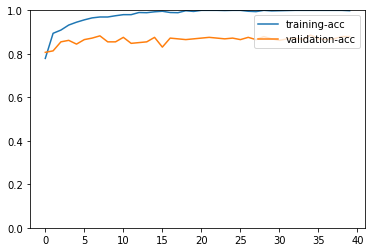

In [ ]:
# training loop
epochs = 40
lr_counter = 0
num_batch = len(train_data)
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, test_data, ctx)
    train_history.update([train_acc, val_acc])
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

train_history.plot(['training-acc', 'validation-acc'])

In [ ]:
# save the learning curve data for later comparison
out_file_name = '/content/gdrive/My Drive/Colab Notebooks/Research_project_embryo/CNN2D-Embryo/embryo58/embryo-58-ResNet50_v2-finetune-data_aug-order-random-dataaug.npz'
np.savez(out_file_name,train_acc = np.asarray(train_acc_list),val_acc = np.asarray(val_acc_list))

### Save and load model
https://mxnet.apache.org/versions/1.6/api/python/docs/tutorials/packages/gluon/blocks/save_load_params.html

In [ ]:
file_name = '/content/gdrive/My Drive/Colab Notebooks/Research_project_embryo/CNN2D-Embryo/embryo58/embryo-58-ResNet50_v2-finetune-data_aug-order-random-dataaug.params'

# Saving model parameters to file
finetune_net.save_parameters(file_name)

In [ ]:
# Loading model parameters from file
finetune_net.load_parameters(file_name, ctx=ctx)
# run on test data
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.879


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Label')

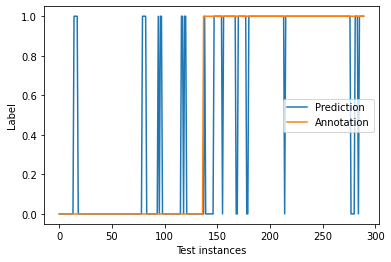

In [ ]:
# summarize test prediction results
record_pred = []
record_label = []
for i, batch in enumerate(test_data):
  data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
  label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
  outputs = [finetune_net(X) for X in data]
  a = np.argmax(outputs[0].asnumpy(),axis=1).astype('int32')
  b = label[0].asnumpy()
  if record_pred == []:
    record_pred = a
    record_label = b
  else:
    record_pred = np.concatenate((record_pred, a), axis=0)
    record_label = np.concatenate((record_label, b), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

[[122  15]
 [ 20 133]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


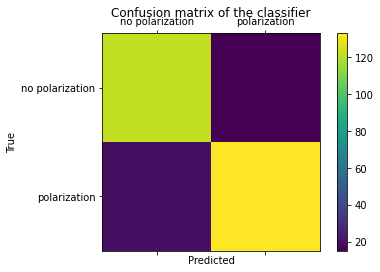

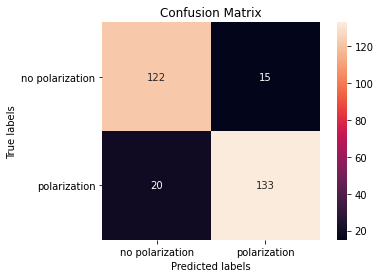

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['no polarization','polarization']
cm = confusion_matrix(record_label, record_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no polarization', 'polarization'])
ax.yaxis.set_ticklabels(['no polarization', 'polarization'], rotation='horizontal')
ax.set_aspect('equal', 'box')

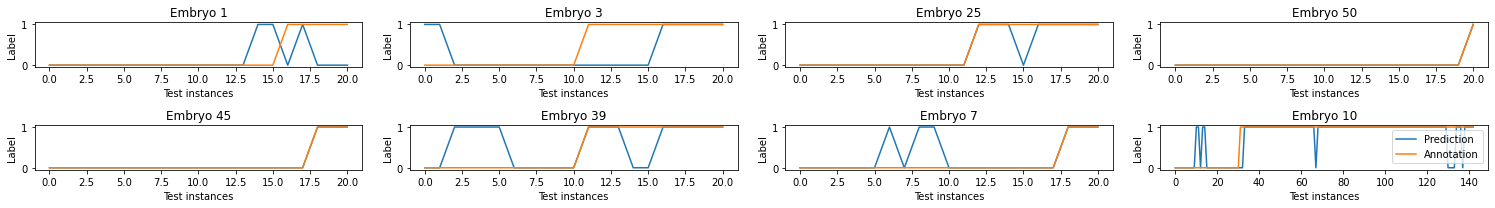

In [ ]:
import pandas as pd

test_path = '/content/gdrive/My Drive/Dataset/embryo-58-bf-image-1503-order-random/usable_embryo_random.xlsx'
dfs = pd.read_excel(test_path)
usable_col = dfs.iloc[:,[0,1,2]].to_numpy()
split_idx = 22

test_embryo_idx = usable_col[split_idx:,0]
test_pol_time = usable_col[split_idx:,1]
test_tot = usable_col[split_idx:,2]

reshape_record_label = np.split(record_label, np.cumsum(np.append(test_pol_time-1, test_tot-test_pol_time+1)))
del reshape_record_label[-1]
new_label_list = []
for k in range(int(len(reshape_record_label)/2)):
  new_label_list.append(np.append(reshape_record_label[k],reshape_record_label[k+int(len(reshape_record_label)/2)]))
# print(np.asarray(new_label_list))

reshape_record_pred = np.split(record_pred, np.cumsum(np.append(test_pol_time-1, test_tot-test_pol_time+1)))
del reshape_record_pred[-1]
new_pred_list = []
for k in range(int(len(reshape_record_pred)/2)):
  new_pred_list.append(np.append(reshape_record_pred[k],reshape_record_pred[k+int(len(reshape_record_label)/2)]))
# print(np.asarray(new_pred_list))

img_col = int(len(new_label_list)/2)
fig, axes = plt.subplots(2, img_col, figsize=(21, 3))
for k in range(len(new_label_list)):
  axes[int(k/img_col), k%img_col].plot(np.arange(len(new_pred_list[k])),new_pred_list[k],label='Prediction')
  axes[int(k/img_col), k%img_col].plot(np.arange(len(new_label_list[k])),new_label_list[k],label='Annotation')
  axes[int(k/img_col), k%img_col].set_xlabel('Test instances')
  axes[int(k/img_col), k%img_col].set_ylabel('Label')
  axes[int(k/img_col), k%img_col].set_title('Embryo '+str(test_embryo_idx[k]))
plt.legend()
plt.tight_layout()

### Attention of CNN

This section refers to https://discuss.mxnet.io/t/how-to-visualize-image-classification-resnetv2/4969

Another similar realization can be seen in https://github.com/nicklhy/CAM/blob/master/cam.ipynb

About Class Activation Maps(CAM):
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [ ]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cv2.resize(cam_img, size_upsample)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_images):
        img = images[i].astype(np.uint8)
        axs[i].set_title(titles[i])

        if len(img.shape)==2:
          im = axs[i].imshow(img, cmap=cmaps[i])
          # create an axes on the right side of ax. The width of cax will be 5%
          # of ax and the padding between cax and ax will be fixed at 0.05 inch.
          divider = make_axes_locatable(axs[i])
          cax = divider.append_axes("right", size="5%", pad=0.05)
          plt.colorbar(im, cax=cax)
        else:
          im = axs[i].imshow(img, cmap=None)
    return fig

In [ ]:
group_id = 1
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
for i, batch in enumerate(fluo_test_data):
    fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break

In [ ]:
# get an image
test_idx = 0
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

(2, 2048) (1, 2048, 16, 16)
Annotated label: no polarization
Network prediction: polarization


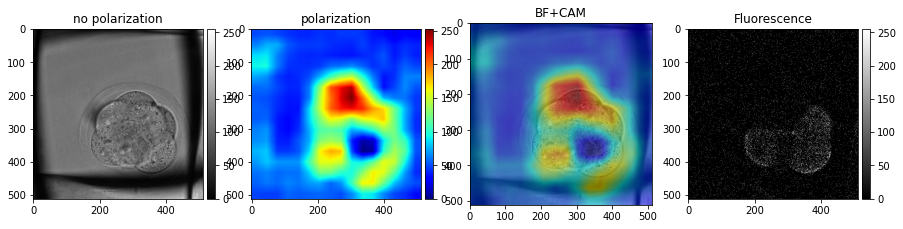

In [ ]:
output = finetune_net(test_image)
classes = ['no polarization','polarization']
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()
print(weight_softmax.shape,features_blob.shape)

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = cv2.resize(CAMs,(width, height))
print('Annotated label: %s'%classes[int(test_label)])
print('Network prediction: %s'%classes[idx])

# convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)*X_std+X_mean
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)
test_image_narray_fluo = np.swapaxes(np.squeeze(test_image_fluo.asnumpy()),0,2)*X_std+X_mean
test_image_narray_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))
test_image_squeeze_fluo = np.squeeze(collapse_same_frame(test_image_narray_fluo))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
overlay = heatmap * 0.5 + test_image_narray * 0.5

images = []
images.append(test_image_squeeze)
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(test_image_squeeze_fluo))

titles = [classes[int(test_label)],classes[idx],'BF+CAM','Fluorescence']
cmaps = ['gray','jet',None,'gray']
fig = show_images(images, titles, cmaps)

# fig.savefig('test_cam.png')

### Failure analysis

In [ ]:
tp = record_pred==record_label
itemindex = np.where(tp==False)
print(itemindex)

(array([117, 119, 137, 140, 141, 147]),)


(2, 2048) (1, 2048, 16, 16)
Network prediction: no polarization
Annotated label: polarization


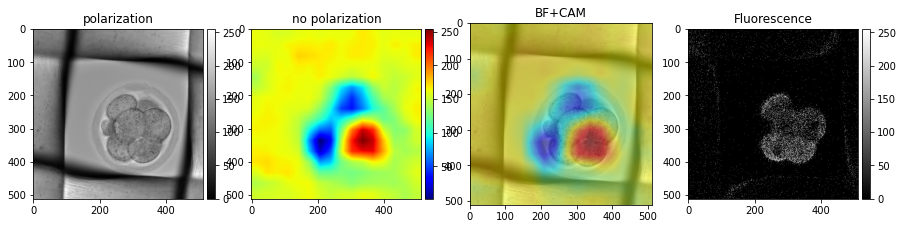

In [ ]:
FN_idx = 0
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
for i, batch in enumerate(fluo_test_data):
    fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

output = finetune_net(test_image)
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()
print(weight_softmax.shape,features_blob.shape)

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = cv2.resize(CAMs,(width, height))
print('Network prediction: %s'%classes[idx])
print('Annotated label: %s'%classes[int(test_label)])

test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)*X_std+X_mean
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)
test_image_narray_fluo = np.swapaxes(np.squeeze(test_image_fluo.asnumpy()),0,2)*X_std+X_mean
test_image_narray_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))
test_image_squeeze_fluo = np.squeeze(collapse_same_frame(test_image_narray_fluo))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
overlay = heatmap * 0.5 + test_image_narray * 0.5

images = []
images.append(test_image_squeeze)
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(test_image_squeeze_fluo))

titles = [classes[int(test_label)],classes[idx],'BF+CAM','Fluorescence']
cmaps = ['gray','jet',None,'gray']
fig = show_images(images, titles, cmaps)

(2, 2048) (1, 2048, 16, 16)
Network prediction: no polarization
Annotated label: polarization


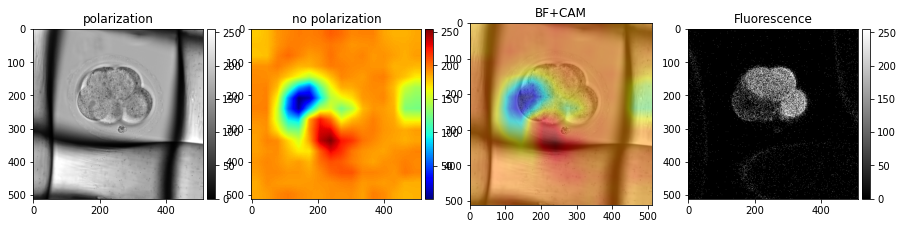

In [ ]:
FN_idx = 1
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
for i, batch in enumerate(fluo_test_data):
    fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

output = finetune_net(test_image)
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()
print(weight_softmax.shape,features_blob.shape)

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = cv2.resize(CAMs,(width, height))
print('Network prediction: %s'%classes[idx])
print('Annotated label: %s'%classes[int(test_label)])

test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)*X_std+X_mean
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)
test_image_narray_fluo = np.swapaxes(np.squeeze(test_image_fluo.asnumpy()),0,2)*X_std+X_mean
test_image_narray_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))
test_image_squeeze_fluo = np.squeeze(collapse_same_frame(test_image_narray_fluo))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
overlay = heatmap * 0.5 + test_image_narray * 0.5

images = []
images.append(test_image_squeeze)
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(test_image_squeeze_fluo))

titles = [classes[int(test_label)],classes[idx],'BF+CAM','Fluorescence']
cmaps = ['gray','jet',None,'gray']
fig = show_images(images, titles, cmaps)

(2, 2048) (1, 2048, 16, 16)
Network prediction: no polarization
Annotated label: polarization


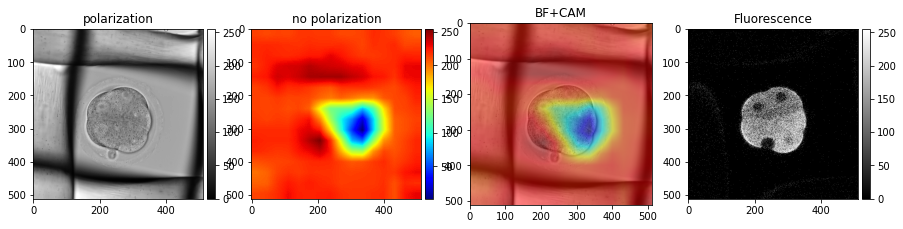

In [ ]:
FN_idx = 2
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
for i, batch in enumerate(fluo_test_data):
    fluo_data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
test_image_fluo = fluo_data[0][test_idx].expand_dims(0)

output = finetune_net(test_image)
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()
print(weight_softmax.shape,features_blob.shape)

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = cv2.resize(CAMs,(width, height))
print('Network prediction: %s'%classes[idx])
print('Annotated label: %s'%classes[int(test_label)])

test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)*X_std+X_mean
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)
test_image_narray_fluo = np.swapaxes(np.squeeze(test_image_fluo.asnumpy()),0,2)*X_std+X_mean
test_image_narray_fluo = (NormalizeData(test_image_narray_fluo)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))
test_image_squeeze_fluo = np.squeeze(collapse_same_frame(test_image_narray_fluo))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
overlay = heatmap * 0.5 + test_image_narray * 0.5

images = []
images.append(test_image_squeeze)
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(test_image_squeeze_fluo))

titles = [classes[int(test_label)],classes[idx],'BF+CAM','Fluorescence']
cmaps = ['gray','jet',None,'gray']
fig = show_images(images, titles, cmaps)